In [113]:
# Import needed libraries
import pickle
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


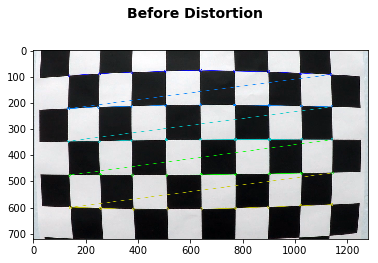

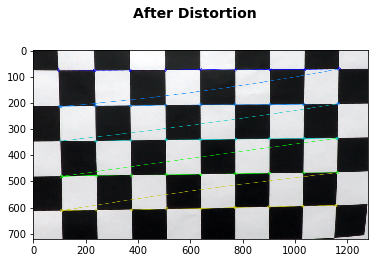

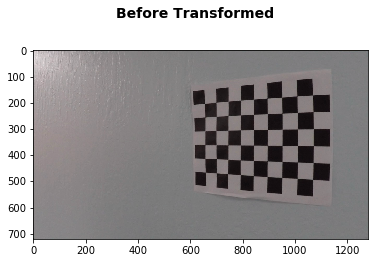

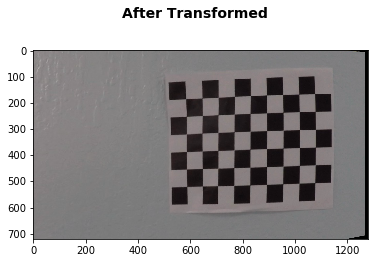

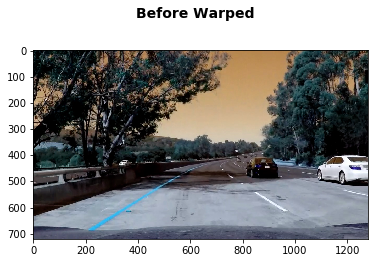

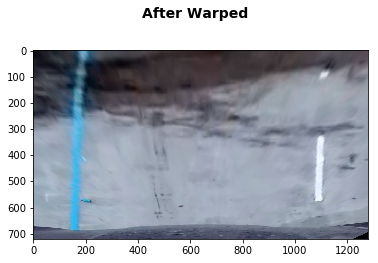

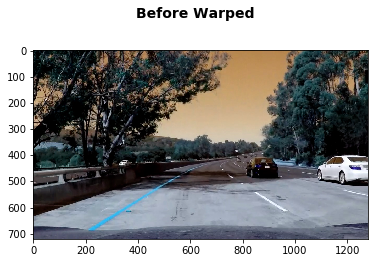

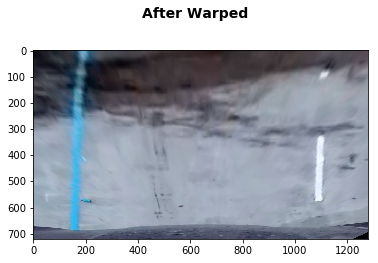

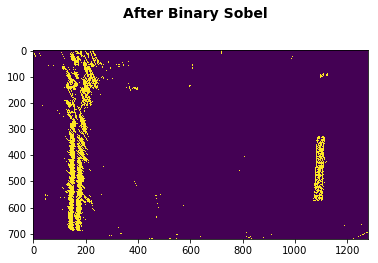

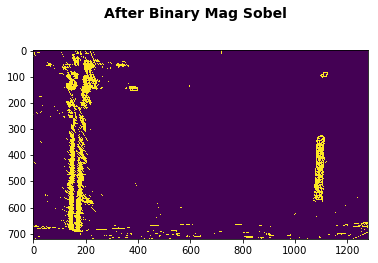

In [114]:
"""
Begin Pipeline
"""

# Read in Images
os.chdir('C:\\Users\\drose\\Google Drive\\mooc\\Udacity\\sdc\\p4\\HiFi-Lane-Tracking')    
import glob
cal_images = []
for img in glob.glob("media\\camera_cal\\*.jpg"):
    n = cv2.imread(img)
    cal_images.append(n)
    
cal1  = cal_images[0]
cal2 = cal_images[3]

test_images = []
for img in glob.glob("media\\test_images\\*.jpg"):
    n = cv2.imread(img)
    test_images.append(n)

"""
Camera Calibration and Distortion Correction
"""
# Color conversion to Gray
def toGray(img):
    #plt.suptitle('Before', fontsize=14, fontweight='bold')
    #plt.imshow(img)
    #plt.show()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #plt.suptitle('After Gray', fontsize=14, fontweight='bold')
    #plt.imshow(gray,cmap='gray')
    #plt.show()
    return gray

# Prepare object points

def toCalibrate(img,nx,ny):
    objpoints = []
    imgpoints = []
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinates
    
    # Find chessboard corners
    ret, corners= cv2.findChessboardCorners(img, (nx,ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        imgpoints.append(corners)
        objpoints.append(objp)
        plt.suptitle('Before Distortion', fontsize=14, fontweight='bold')
        plt.imshow(img)
        plt.show()

        global mtx
        global dist
        global rvecs
        global tvecs
        global undist
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, toGray(img).shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        plt.suptitle('After Distortion', fontsize=14, fontweight='bold')
        plt.imshow(undist)
        plt.show()
    if ret == False:
        print('Did not find any corners')
        
def toDistort(img,mtx,dist):
    global undist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    plt.suptitle('Before Distortion', fontsize=14, fontweight='bold')
    plt.imshow(img)
    plt.show()

    plt.suptitle('After Distortion', fontsize=14, fontweight='bold')
    plt.imshow(undist)
    plt.show()
    return undist

    
        

        
def toWarp(img,src,dst,undist):     
    # Grab the image shape
    img_size = (toGray(img).shape[1], toGray(img).shape[0])

    plt.suptitle('Before Transformed', fontsize=14, fontweight='bold')
    plt.imshow(img)
    plt.show()
    #print(np.shape(gray))
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    global warped
    warped = cv2.warpPerspective(img, M, img_size)
    plt.suptitle('After Transformed', fontsize=14, fontweight='bold')
    plt.imshow(warped)
    plt.show()
    #return warped

src = np.float32([[600, 140], # Top-Left
          [1200, 60], 
          [1200, 570], 
          [600, 520]])
# Destination is just filling whole frame for now
dst = np.float32([[500, 100], # Top-Left
              [1200, 60], 
              [1200, 570], 
              [500, 600]])

"""
Color/Gradient Threshold
Canary, x/y, HSL conversion, Sobel
"""
def toSobel(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    if len(np.shape(img)) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    global binary_output
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    plt.suptitle('After Binary Sobel', fontsize=14, fontweight='bold')
    plt.imshow(binary_output)
    plt.show()
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def toMagSobel(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    if len(np.shape(img)) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    plt.suptitle('After Binary Mag Sobel', fontsize=14, fontweight='bold')
    plt.imshow(binary_output)
    plt.show()
    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    if len(np.shape(img)) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    plt.imshow(binary_output)
    plt.show()
    # Return the binary image
    return binary_output


nx, ny = 9, 5
toCalibrate(cal1, nx=nx,ny=ny)
toWarp(cal2,src=src,dst=dst,undist=undist)

"""
Perspective Transform
Birds Eye View
"""
def toWarp(img,src,dst,undist=undist):     
    # Grab the image shape
    if len(np.shape(img)) > 2:
        img_size = (toGray(img).shape[1], toGray(img).shape[0])
    else:
        img_size = (img.shape[1], img.shape[0])
    

    plt.suptitle('Before Warped', fontsize=14, fontweight='bold')
    plt.imshow(img)
    plt.show()
    #print(np.shape(gray))
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    global warped
    warped = cv2.warpPerspective(img, M, img_size)
    plt.suptitle('After Warped', fontsize=14, fontweight='bold')
    plt.imshow(warped)
    plt.show()
    return warped

src = np.float32([[500, 500], # Top-Left
          [800, 500], 
          [1280, 720], 
          [0, 720]])
# Destination is just filling whole frame for now
dst = np.float32([[120, 0], # Top-Left
              [1170, 0], 
              [1220, 720], 
              [0, 720]])
step0 = toWarp(test_images[6], src=src,dst=dst)
step05 = toWarp(test_images[6], src=src,dst=dst)
hls = cv2.cvtColor(step0, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

#step1 = toDistort(S)
step1 = S
step2 = toSobel(step1,thresh_min=10, thresh_max=100)
step25 = toMagSobel(step1, mag_thresh=(10,100))
#step3 = toMagSobel(step2, sobel_kernel=9, mag_thresh=(30, 100))
#toMagSobel(step1, sobel_kernel=9, mag_thresh=(30, 100))
#dir_threshold(step3, sobel_kernel=15, thresh=(0.7, 1.3))
#step3 = dir_threshold(step2, sobel_kernel=15, thresh=(0.7, 1.3))


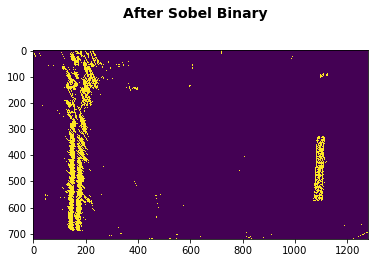

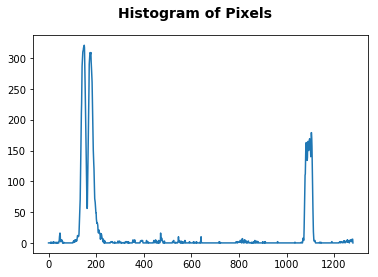

In [115]:
plt.suptitle('After Sobel Binary', fontsize=14, fontweight='bold')
plt.imshow(step2)
plt.show()

histogram = np.sum(step2[step2.shape[0]//2:,:], axis=0)
plt.suptitle('Histogram of Pixels', fontsize=14, fontweight='bold')
plt.plot(histogram)
plt.show()


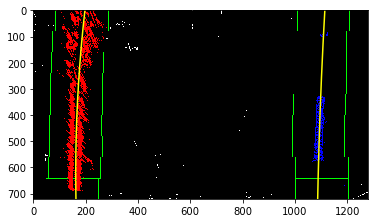

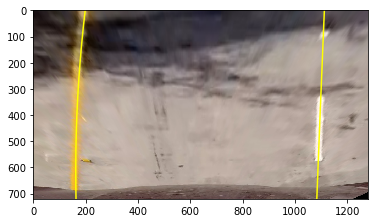

5224.08153427 178789.385242


In [116]:
"""
Sliding Window Code (From Udacity Excercise)
"""

binary_warped = step2
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot it!
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()


# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#plt.imshow(result) #the scatter blank image?
fig = plt.figure()
plt.imshow(cv2.cvtColor(step0, cv2.COLOR_BGR2RGB))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.plot(test_images)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

#print(left_fitx)


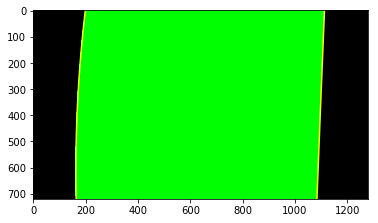

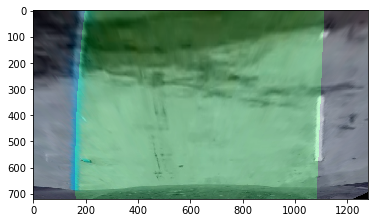

In [124]:
"""
Add polygon and Overlay and Warp
"""

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
plt.imshow(color_warp)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.show()
#toWarp(fig,src=src,dst=dst)
step00 = step0.copy()
alpha = 0.2
temp = cv2.addWeighted(color_warp, alpha, step00, 1 - alpha,0, step00)
plt.imshow(temp)
plt.show()


def unwarp(warped, M):
    img = warped
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(warped, M, img_size, cv2.WARP_INVERSE_MAP)



In [118]:
"""
Polynomial Method, may not need?
"""

# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(window_img, left_line_pts, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
#plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

TypeError: expected 1D vector for x

In [ ]:
left_fit